In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Risk and Loss Minimization

Regularization, train-test split, and cross-validation all have the goal to reduce over-fitting. The problem with over-fitting comes from using data to both fit a model and estimate the model's error in predicting new observations. In this section, we formalize this idea.

Throughout this book, our approach to fitting and evaluating models has taken the perspective of minimizing loss. 
We first introduced the notion of a loss function in {numref}`Chapter %s <ch:modeling>` where we used absolute loss to fit a constant to data.  There, the loss function was simply $ {\cal l}(\theta, y) = | y - \theta | $. Then, in {numref}`Chapter %s <ch:linear>` we introduced the multiple linear model and used squared loss to fit them, with the loss function  $ {\cal l}(\theta, \mathbf{x}, y) = (y - \mathbf{x}\boldsymbol{\theta})^2$. Here $ \mathbf{x} $ consists of $ p $ features and  $ \boldsymbol{\theta} $ contains $ p $ coefficients (aka parameters), one for each feature. In {numref}`Chapter %s <ch:logistic>`, we use cross-entropy loss  for the situation when $y$ represents a categorical feature and takes on values of 0 and 1, only. Our focus is on squared loss in this chapter.

 
Generally speaking, a loss function ${\cal l}(f, \mathbf{x}, y)$ gives the model's loss for a single data point where we use $ f(\mathbf{x}) $ to predict $ y $. So for squared loss, we have  

$$ {\cal l}(f, \mathbf{x}, y) = (y - f(\mathbf{x}))^2 $$

In model fitting, we have minimized average loss, $ L(f, \textbf{X}, \mathbf{y}) $,

$$
\begin{aligned}
L(f, \textbf{X}, \mathbf{y}) & = \frac{1}{n} \sum_{i = 1}^{n}{\cal l}(f, \mathbf{x}_i, {y_i}) 
\end{aligned}
$$

Here $ \textbf{X} $ is an $ n \times p $ design matrix, and $ \mathbf{x}_i $ is the $i$th row of the design matrix, which corresponds to the $ i $th observation in the data set. For multiple linear models and squared error, we have an average loss: 

$$
\begin{aligned}
L(\boldsymbol{\theta}, \textbf{X},  \mathbf{y})
& =  \frac{1}{n} \sum_{i = 1}^{n} (y_i - \mathbf{x}_i\boldsymbol{\theta})^2 \\
\end{aligned}
$$

The average loss is an approximation for the expected loss for a new observation. We describe expected loss next.  

## Loss for a New Observation

The train-test split and cross-validation are techniques to estimate the loss for a new observation, an observation that we have not come across as we fit our model. In essence these techniques aim to mimic the expected loss for a new observation. We call this expected loss the  **risk** for a model $ f $. That is if we have a new observation $ (\mathbf{x}_0 , y_0) $, the risk is expressed as 

$$
\begin{aligned}
R(f) & = \mathbb{E}[ {\cal l}(f, \mathbf{x}_0, {y_0}) ] 
\end{aligned}
$$

Since we don't know the underlying distribution of $ (\mathbf{x}_0 , y_0) $, we can't calculate the risk, but we can approximate it by the average loss over the data we have collected:

$$
\begin{aligned}
R(f) & = \mathbb{E}[ {\cal l}(f, \mathbf{x}_0, {y_0}) ] \\
 & \approx 
 \frac{1}{n} \sum_{i = 1}^{n} (y_i - f(\mathbf{x}_i))^2 \\
\end{aligned}
$$

This approximation goes by the name of *empirical risk*. But, hopefully you recognize it as mean square error (MSE).  

When model fitting we find the model, $ \hat{f} $ that minimizes the risk over all possible models, $ \cal{F} = \{ f \} $,

$$
\begin{aligned} 
 \min_{f \in \cal{F}} R(f) = 
 \min_{f \in \cal{F}} \frac{1}{n} \sum_{i = 1}^{n}  (y_i - f(\mathbf{x}_i))^2 \\
\end{aligned}
$$

This technique is aptly called *empirical risk minimization*. The collection of models could be linear models,
$ f( \mathbf{x}) = \mathbf{x} \boldsymbol{{\theta}} $, or degree 2 polynomial models, 
$ f({x}) = \theta_0 + \theta_1x + \theta_2 x^2 $, or other types of models.

In this chapter, we have seen problems arise when we use the empirical risk to both fit a model and evaluate it. When we estimate the risk of a new observation empirically, we have 

$$
\begin{aligned} 
  \frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{f}(\mathbf{x}_i))^2, ~\textrm{where}
\end{aligned}
$$

the data have been used to find $ \hat{f} $ and to estimate the risk. The train-test split helps us get around this problem,
$$
\begin{aligned} 
  \frac{1}{n_S} \sum_{j = 1}^{n_S} (y_j - \hat{f}_T (\mathbf{x}_j))^2, ~\textrm{where}
\end{aligned}
$$

we the notation, $ \hat{f}_T $ means that we have used the train set to fit the model. The risk for a new observation is approximated by $ y_j $ and $ \mathbf{x}_j $ from the test set. Regularization takes a different approach and penalizes the empirical risk minimization to keep the model from fitting the data too closely.  Ideally, we want to estimate the risk 

$$
\begin{aligned}
\mathbb{E}[R({\hat{f}})]  = \mathbb{E}[ (y_0 - \hat{f}(\mathbf{x}_0))^2 ],
\end{aligned}
$$

where the expected value is over both the new observation $ (\mathbf{x}_0, y_0) $ and over $ {\hat{f}} $ (which involves the original data $ \textbf{x}_i$ and $ {y}_i $, $ i = 1, \ldots, n $. 

Before we examine this expectation in greater detail, we provide an example that shows how this risk can be broken down into three pieces: model bias, model variance, and irreducible error.  

## Model Bias and Variance

A general model of data might be expressed as follows:

$$ y = g(\mathbf{x}) + {\epsilon}.$$

The errors are assumed to have no trends or patterns, constant variance, and independent of one another. The *signal* in the model is the function, $g()$. The data are the $ (\mathbf{x}_i, y_i) $ pairs, and we fit models by minimizing the empirical risk, 

$$
\min_{f \in \cal{F}} \frac{1}{n} \sum_{i = 1}^{n} (y_i - f(\mathbf{x}_i)^2 
$$

Note that $g$ might not be in the collection of functions that we are using to fit a model.

As an example, let's take $ g(x) = \sin(x) + 0.3x $ and add errors are from a normal curve to get $ y $.
The following functions set up this data generation process.

In [2]:
def g(x): return np.sin(x) + 0.3 * x

def noise(n):
    return np.random.normal(scale=0.2, size=n)

def draw(n):
    points = np.random.choice(np.arange(0, 10, 0.05), size=n)
    return points, g(points) + noise(n)

We generate 50 $ (x, y) $ pairs from this model and plot them.

In [3]:
np.random.seed(42)
xs, ys = draw(50)
error = ys-g(xs)

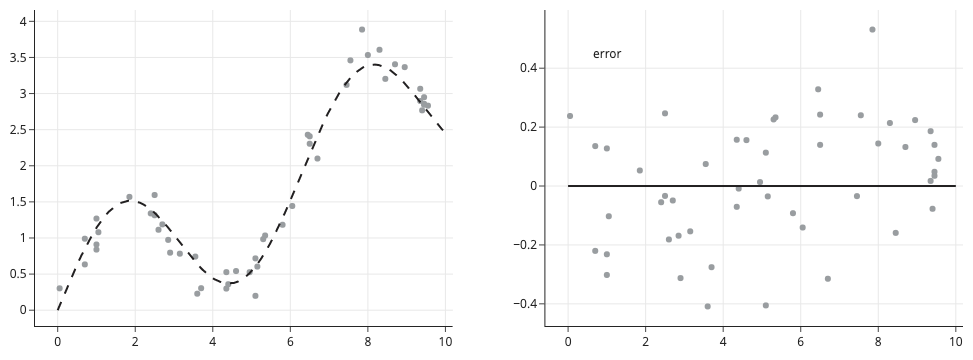

In [4]:
x_full = np.linspace(0, 10, num=100)
y_true = g(x_full)
pewter = 'rgba(153, 157, 160, 1)'
charcoal = 'rgba(34, 32, 33, 1)'

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=xs, y=ys, mode='markers',
              line_color=pewter),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=x_full, y=y_true,
              line_dash='dash',
              line_color=charcoal),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=xs, y=error, mode='markers',
              line_color=pewter),
    row=1, col=2)

fig.add_trace(
    go.Scatter(x=[0, 10], y=[0, 0], mode='lines',
               line_color=charcoal),
    row=1, col=2)

fig.add_annotation(x=1, y=0.45, 
            text="error", showarrow=False,
             row=1, col=2)


fig.update_layout(height=250, width=450, showlegend=False)
fig.show()

The plot on the left shows $g$ as a dashed curve. We can also see the $ (x, y) $ pairs form a scatter of dots about this curve. The right hand plot shows the errors, $ y - g(x) $, for the 50 points. Notice that they do not form a pattern.  

Now let's fit a second degree polynomial to these data. In other words, we take $\cal{F}$ to be the collection of all functions that can be expressed as $ \theta_0 + \theta_1 x + \theta_2 x^2$. Since $ g(x) = \sin(x) + 0.3x $, it doesn't belong to the collection of functions that we are optimizing over. 

In [5]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(xs.reshape(-1,1))

model_deg2 = LinearRegression().fit(poly_features, ys)
model_deg2.coef_

array([-0.19,  0.05])

Again, we know the true model is not quadratic (because we built it). Let's plot the data and the fitted curve.

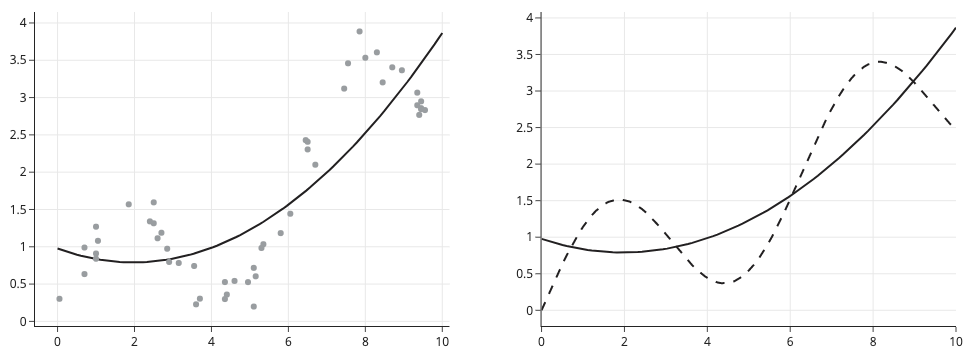

In [6]:
poly_features_x_full = poly.fit_transform(x_full.reshape(-1, 1))   
ys_fit_full = model_deg2.predict(poly_features_x_full).flatten()

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=x_full, y=ys_fit_full, 
               line_color=charcoal),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=xs, y=ys, mode='markers',
              line_color=pewter),
    row=1, col=1)

fig.add_trace(
    go.Scatter(x=x_full, y=ys_fit_full, 
               line_color=charcoal),
    row=1, col=2)

fig.add_trace(
    go.Scatter(x=x_full, y=y_true, line_dash='dash',
               line_color=charcoal),
    row=1, col=2)


fig.update_layout(height=300, width=500, showlegend=False)
fig.show()

The quadratic doesn't fit the data well, and it doesn't represent the underlying curve well either.  There is *model bias* present in this fitting procedure because the set of models that we are fitting to the data (second order polynomials) does not include the truth, $ g $. 

If we repeat this process, and generate another 50 points from the true  model and fit a second degree polynomial to these data, then the fitted coefficients of the quadratic will change because it depends on the new set of data. We can repeat this process many times, and average the fitted curves. This average curve will resemble the expected curve, $ \mathbb{E}[ \hat{f} ] $. To demonstrate this, let's generate 25 sets of data and fit a quadratic to each set of points.

In [7]:
def fit(n):
    xs_new = np.random.choice(np.arange(0, 10, 0.05), size=n)
    ys_new = g(xs_new) + noise(n)
    X_new = xs_new.reshape(-1,1)
    mod_new = LinearRegression().fit(poly.fit_transform(X_new), ys_new)
    return mod_new.predict(poly_features_x_full).flatten()   

In [8]:
fits = [fit(50) for j in range(25)]

The plot below shows all 25 fitted models along with the true function, $g$, and the average of the fitted curves $ \bar{f} $.

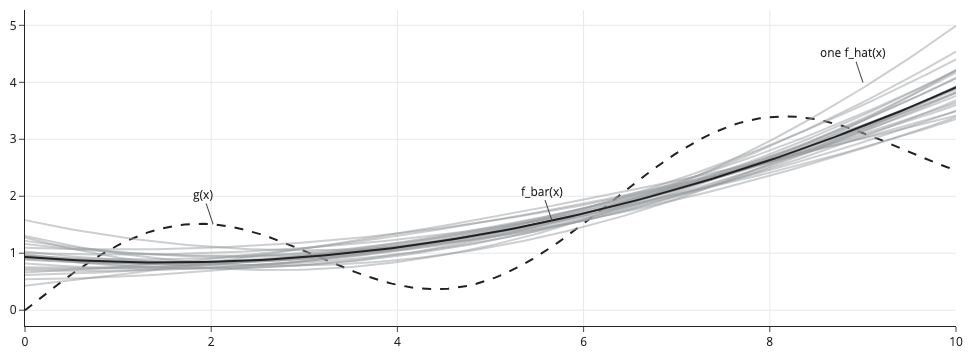

In [9]:
fig = go.Figure()

fig.add_trace(
        go.Scatter(x=x_full, y=y_true, 
                   line_color=charcoal,
                  line_dash='dash')
)

for j in range(25):
    fig.add_trace(
        go.Scatter(x=x_full, y=fits[j], line_color='rgba(153, 157, 160, 0.5)'))
    
fig.add_trace(
        go.Scatter(x=x_full, y=np.mean(fits, axis=0), 
                   line_color=charcoal))


fig.add_annotation(x=2.02, y=1.51, 
            text="g(x)")

fig.add_annotation(x=9, y=4.0,
            text="one f_hat(x)")

fig.add_annotation(x=5.66, y=1.57,
            text="f_bar(x)")
    
fig.update_layout(height=300, width=400, showlegend=False)
fig.show()   

We can see the 25 fitted quadratics vary with the data. This concept is called *model variation*. The average of the 25 quadratics is represented by the solid black line. The difference between the average quadratic and the true curve is called the *model bias*. 

Now, let's return to the general problem. We can decompose the risk for square loss into parts representing the model bias, model variance, and the *irreducible error* from $ \epsilon $.

$$
\begin{aligned}
R & = \mathbb{E} [ y_0 -  \hat{f}(x_0)]^2   & \textrm{definition}~\textrm{of} ~R\\
 &  = \mathbb{E} [ g(x_0) + \epsilon -  \hat{f}(x_0)]^2  & \textrm{definition}~\textrm{of} ~y\\
  &  = \mathbb{E} [ g(x_0) + \epsilon - \mathbb{E}[\hat{f}(x_0)] + \mathbb{E}[\hat{f}(x_0)] -  \hat{f}(x_0)]^2 & \textrm{adding}~ \pm \mathbb{E}[\hat{f}(x_0)] \\
 &  = \mathbb{E} [ g(x_0) - \mathbb{E}[\hat{f}(x_0)] -  (\hat{f}(x_0) - \mathbb{E}[\hat{f}(x_0)]) + \epsilon]^2  & \textrm{rearranging}~\textrm{terms}\\
 &  = [ g(x_0) - \mathbb{E}[\hat{f}(x_0)]]^2 + \mathbb{E}[\hat{f}(x_0) - \mathbb{E}[\hat{f}(x_0)]]^2 + \sigma^2 \\
% & =  ~~~\textrm{model bias}^2 ~~~~~~~+~~~~ \textrm{model variance}^2 ~+~ \textrm{error}
\end{aligned}
$$

(To derive the last equality from the previous line, we need to formally prove that the cross product terms in the expansion of the quadratic are all 0. This takes quite a bit of algebra and we don't present it here.) The first of the three terms in the final equation is model bias (squared). When, the signal, $ g $,  does not belong to the model space, we have model bias. If the model space can approximate $g$ well, then the bias is small. For instance, a 10-degree polynomial can get pretty close to the $g$ used in our example.  The second term represents the variability in the fitted model that comes from the data. We have seen earlier in this chapter that higher degree polynomials over fit the data, so they vary a lot from one set of data to the next. The more complex the model space, the greater the variability in the fitted model. Finally, the last term is the variability in the errors, the "irreducible error".  This error sticks around whether we have under fit with a simple model (high bias) or over fit with a complex model (high variance).

This representation of the expected loss is called the *bias-variance decomposition* of the model. Model selection aims to balance these competing sources of error. This balancing problem is called the *bias-variance trade off*.